Testing parallel options:
- with separate DiaObjectLast table used as index for last version of DiaSource
- Storage is SSD
- FOV is split into rectangular tiles and each tile is processed in separate process
- all database queries are done on per-tile basis

Beacuse there are many things running in parallel it's pointless to compare time per individual query, so here we compare times per whole visit processing


In [1]:
%pylab inline
plt.style.use('bmh');

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
def do_plot(ds, name, y=['visit_real'], figsize = (8, 5)):
    ds.plot(y=y, style=['o', 'r+'], title=name, figsize=figsize)

def do_boxplot(ds, by_col_name, columns, title='', bin=100, figsize=(8, 4)):
    for col in columns:
        ds.boxplot(col, by=by_col_name, figsize=figsize, showmeans=True, sym='x', whis='range')
        x = ds.index
        y = ds[col]
        try:
            x = x/bin
            p = polyfit(x, y, 1)
            y = x*p[0] + p[1]
            label = "fit: {:.3f} + {:.3f}*visit/1000".format(p[1], p[0])
            # x + 1 is needed because boxplot draws in strange coordinates
            plt.plot(x+1, y, "--g", label=label)
            plt.legend()
        except:
            pass

        plt.title("")
        plt.suptitle(title + ": " + col)

def do_plots(file_name, title, bin=100, filter_count=True, bad_visits=None, 
             what=['scatter', 'counts', 'box'], time='visit_real'):
    ds = pd.read_csv(file_name, header=0, index_col='visit')
    if filter_count:
        # filter out records doing COUNT(*) which takes long time
        dscount = ds[ds.src_count.notnull()]
        ds = ds[ds.src_count.isnull()]
    if bad_visits:
        ds.drop(bad_visits, inplace=True)
    ds = ds.fillna(0, axis=1)
    
    # do "scatter" plot
    if 'scatter' in what:
        do_plot(ds, title, y=[time])
    if 'counts' in what:
        do_plot(dscount, title, y=['obj_count', 'src_count'], figsize=(8, 4))
    
    # box plots
    if 'box' in what:
        col_name = 'visit/' + str(bin)
        ds[col_name] = np.array(ds.index/bin, dtype=int64)
        do_boxplot(ds, col_name, [time], bin=bin, title=title)

    return ds

MySQL with whole FOV processing (no tiles)
=================================

These numbers is actually from the previous tests, I did not repeat it.

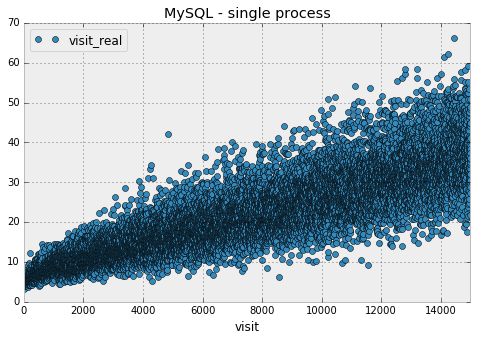

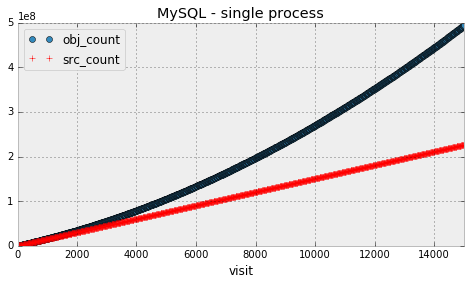

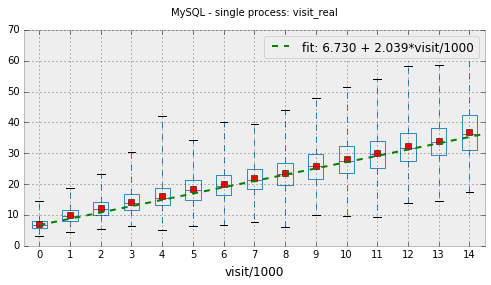

In [4]:
ds = do_plots("data/dm-9301-mysql-no-tiles.csv.gz", "MySQL - single process", bin=1000)

MySQL with 5x5 tiles
=====================================

There was an issue in visit 14439, mysql timed out on many clients with error "Lock wait timeout exceeded".

Processing runs about 4 times faster.

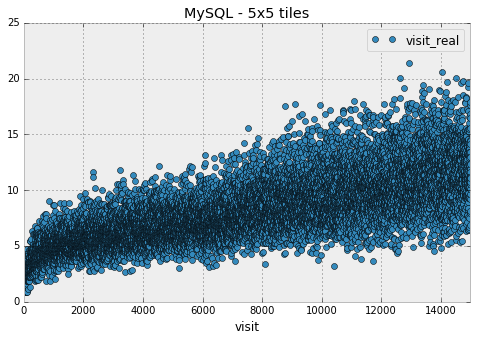

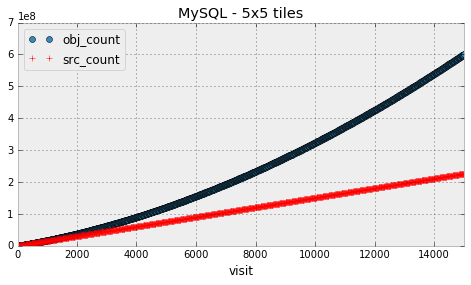

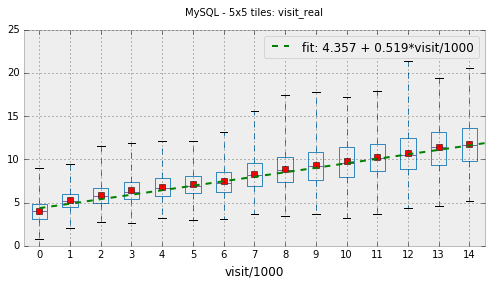

In [5]:
ds = do_plots("data/dm-9301-mysql-5x5.csv.gz", "MySQL - 5x5 tiles", bin=1000, bad_visits=[14439]);

Postgres with whole FOV(no tiles)
==================================

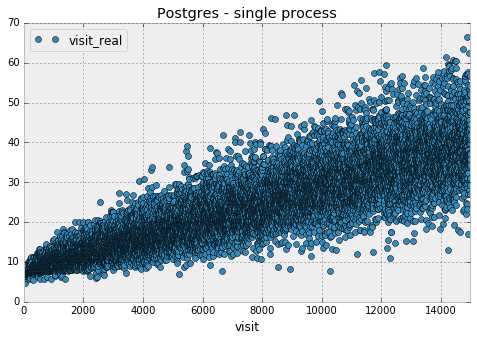

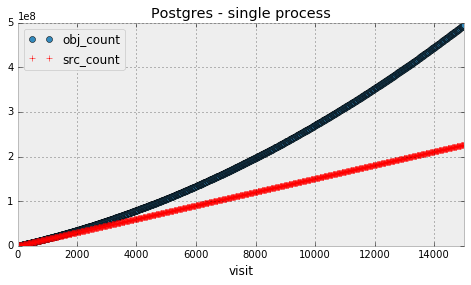

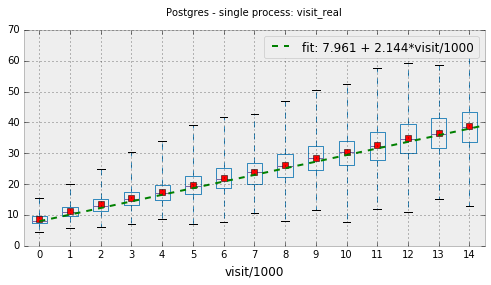

In [6]:
ds = do_plots("data/dm-9301-pg-no-tiles.csv.gz", "Postgres - single process", bin=1000)

Postgres with 5x5 tiles
=======================


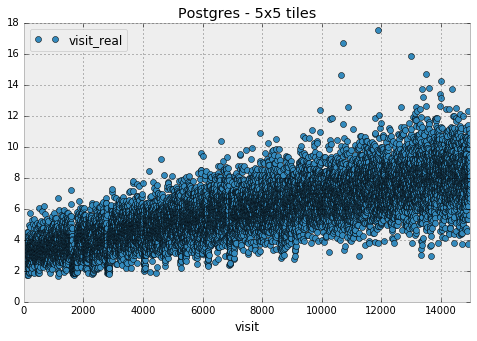

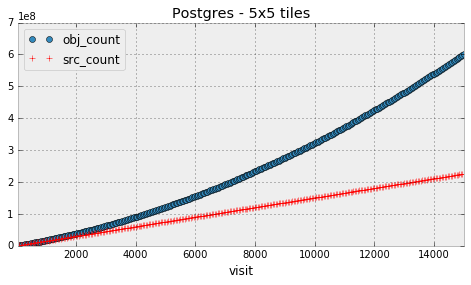

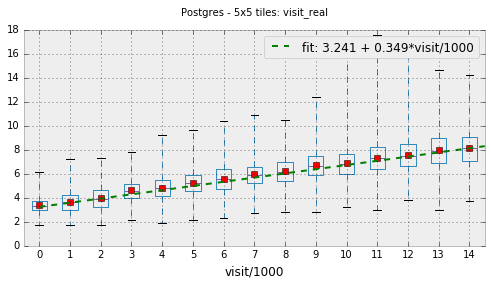

In [7]:
ds = do_plots("data/dm-9301-pg-5x5.csv.gz", "Postgres - 5x5 tiles", bin=1000)

Postgres with 15x15 tiles
=======================

I think we observe a SSD "write cliff" after ~11,000 visits. These tests are on SATA SSD storage which is connected as RAID-0 array (made from two 1.6TB SSDs) to a RAID controller.

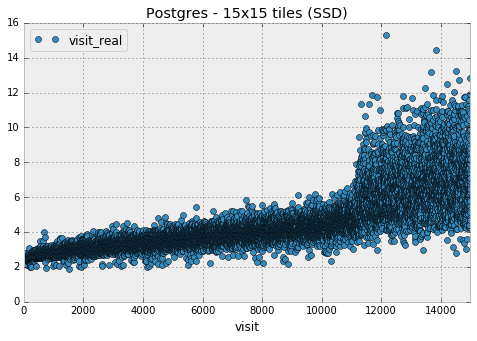

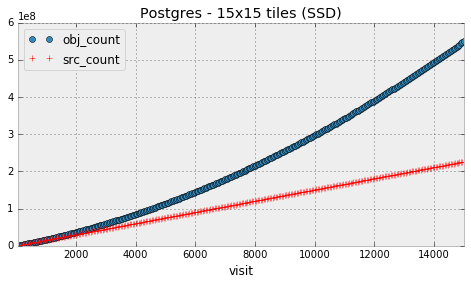

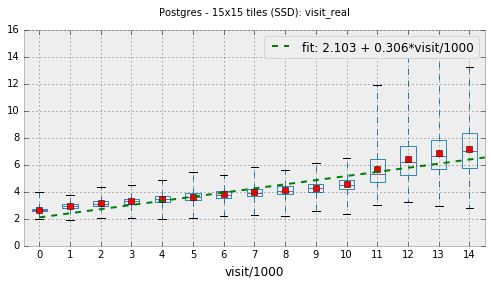

In [8]:
ds = do_plots("data/dm-9301-pg-15x15.csv.gz", "Postgres - 15x15 tiles (SSD)", bin=1000)

Postgres 15x15 after cleanup
===============
This is a repat of the same test (incomplete) after removing few databases from Postgres instance and disabling auto-vacuum. There is still sign of degradation, though this is probably related to disabled auto-vacuum. At visit 1000 "VACUUM" was ran on a database, which improved things a little bit but maybe only temporariliy.

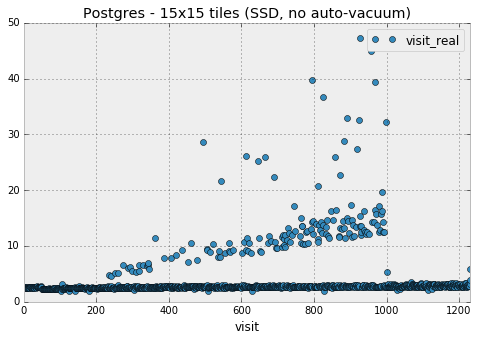

In [9]:
ds = do_plots("data/dm-9301-pg-15x15-02.csv.gz", "Postgres - 15x15 tiles (SSD, no auto-vacuum)", what=['scatter'])

Postgres 15x15 on NVMe
===============

This test is done on NVMe disk, after running `fstrim`. Auto-vacuum is disabled and "VACUUM ANALYZE" runs on every 1000 visits. There is still something weird happening in first 1000 visits, likely this is due to disabled auto-vacuum.

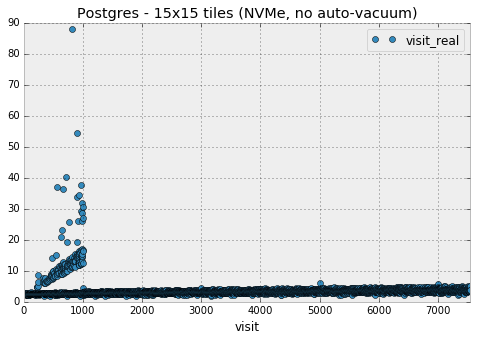

In [10]:
ds = do_plots("data/dm-9301-pg-15x15-03.csv.gz", "Postgres - 15x15 tiles (NVMe, no auto-vacuum)", what='scatter')

Re-enabling auto-vacuuming fixes behavior. There is also manual vacuuming every 1000 visits, no signs that it helps anything.

**NOTE** Plots below show time excluding Source generation time (DIA step of ap_proto) which is small and constant.

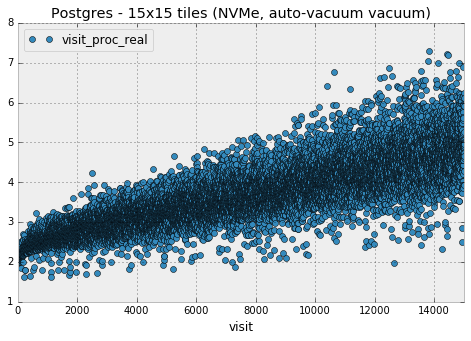

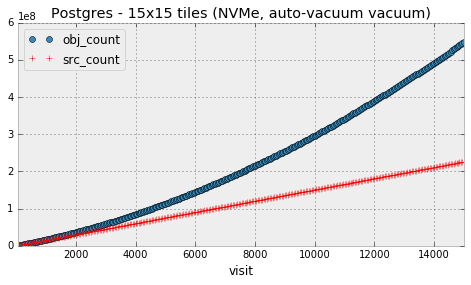

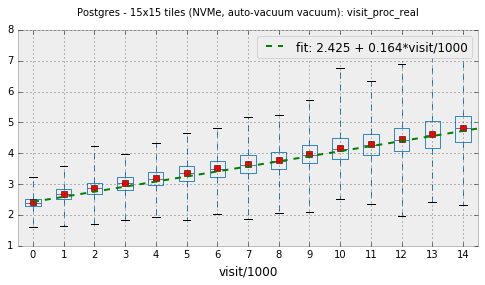

In [11]:
ds = do_plots("data/dm-9301-pg-15x15-nvme-04.csv.gz", "Postgres - 15x15 tiles (NVMe, auto-vacuum vacuum)", 
              bin=1000, time='visit_proc_real')

Repeat of the test on SSD, freeing space on disk and enabling auto-vacuum.

Performance is somewhat worse than NVMe, likely NVMe has much better parallelism.

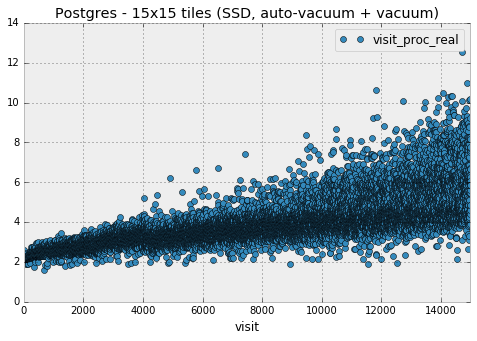

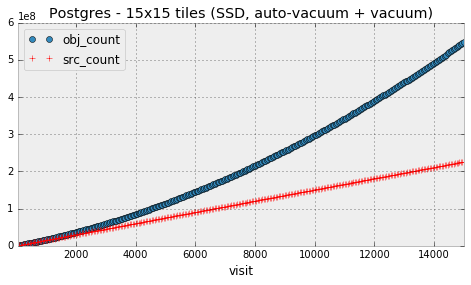

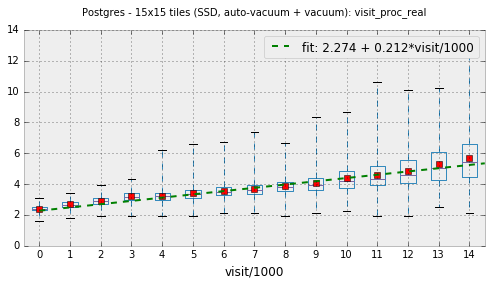

In [12]:
ds = do_plots("data/dm-9301-pg-15x15-ssd-05.csv.gz", "Postgres - 15x15 tiles (SSD, auto-vacuum + vacuum)", 
              bin=1000, time='visit_proc_real')

MySQL 15x15 on NVMe
==============

Significantly slower as Postgres.

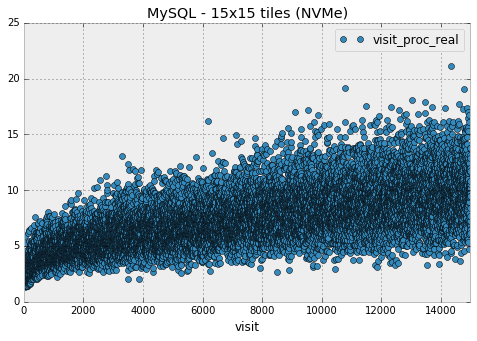

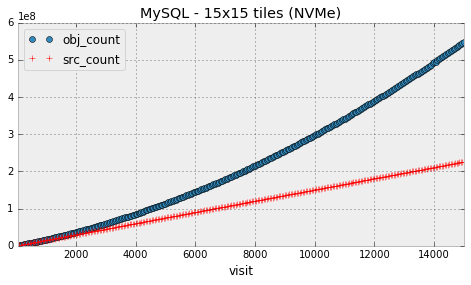

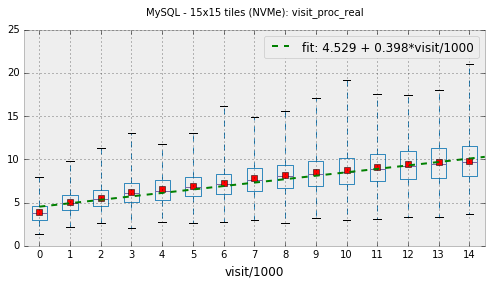

In [13]:
ds = do_plots("data/dm-9301-mysql-15x15-nvme-01.csv.gz", "MySQL - 15x15 tiles (NVMe)",
              bin=1000, time='visit_proc_real');